# __Travail Pratique 6 : Introduction au benchmarking de réseaux de neurones artificiels sur des données transcriptomiques de cancers__

#### <u>Importation des modules nécessaires</u>

In [5]:
import os
import umap
import h5py
import random
import sklearn
import datetime 
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt 
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from scipy.stats import pearsonr
import torch
from torch import nn
import torch.nn.functional as F

# Custom
import common.plotting
import common.dataprocessing

## __Première partie : Annexe__

### **Étape I : Importation et visualisation des données avec UMAP**

#### <u>Importation des données</u>

In [2]:
inf = "../data/TP6/TCGA_BRCA_fpkm_hv_norm_PAM50.h5"
dataset = h5py.File(inf)

In [3]:
# Extraires les différentes variables du jeux de données
brca_data = dataset["data"][:,:]
labels = np.array(dataset["labels"][:], dtype = str)
samples = np.array(dataset["samples"][:], dtype = str)
genes = np.array(dataset["genes"][:], dtype = str) # Type de tissus dans TCGA

targets = np.unique(labels)
count_df = pd.DataFrame(brca_data).T
labels_df = pd.DataFrame(labels)
count_df["labels"] = labels

#### <u>Initialisation des fonctions de visualisation des performances</u>

In [4]:
def plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test):
    steps = np.arange(len(trl))
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 8))
    axes[0].plot(steps, trl, label = "train")
    axes[0].plot(steps, tstl, label= "test")
    axes[1].plot(steps, trc, label = "train")
    axes[1].plot(steps, tstc, label= "test")
    axes[0].set_ylabel("MSELoss")
    axes[1].set_ylabel("Pearson Correlation")
    axes[1].set_ylim((0,100))
    axes[1].set_xlabel("Gradient step")
    axes[0].legend()
    axes[0].set_title(f"Learning curves of DNN on ML data\nN={tpm_data.shape[1]}, N(train)={X_train.shape[0]}, N(test)={X_test.shape[0]}")

def plot_ae_performance(mm, X_test):
    y_tst_out = mm(X_test)
    outs = y_tst_out.flatten().detach().numpy()
    trues = X_test.flatten().detach().numpy()
    corr =  pearsonr(outs,trues).statistic
    plt.figure(figsize = (9,7))
    plt.grid(visible =True, alpha = 0.5, linestyle = "--")
    plt.plot([0,1],[0,1], color = "blue", alpha =0.5, linestyle = "--")
    plt.hexbin(outs, trues, bins = "log")
    plt.xlabel("Predicted Expressions (normalised TPM)")
    plt.ylabel("True expressions")
    plt.colorbar(label='log10(N)')
    plt.axis("equal")
    plt.title(f"Auto-Encoder performance of reconstruction on test set.\nPearson Correlation: {round(corr,4)}")

#### <u>Visualisation avec UMAP</u>

In [6]:
# Séparation des données d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(brca_data.T, labels, test_size = 0.2)

In [6]:
mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
    n_neighbors =20, n_epochs = 1000).fit(X_train) 

# Transformation des données d'entraînement et de test
X_tr_umap = mapper.transform(X_train)
X_tst_umap = mapper.transform(X_test)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=20, verbose=1)
Wed Dec  6 13:12:51 2023 Construct fuzzy simplicial set
Wed Dec  6 13:12:52 2023 Finding Nearest Neighbors
Wed Dec  6 13:12:55 2023 Finished Nearest Neighbor Search
Wed Dec  6 13:12:57 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Wed Dec  6 13:13:03 2023 Finished embedding


Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs
(818, 2)


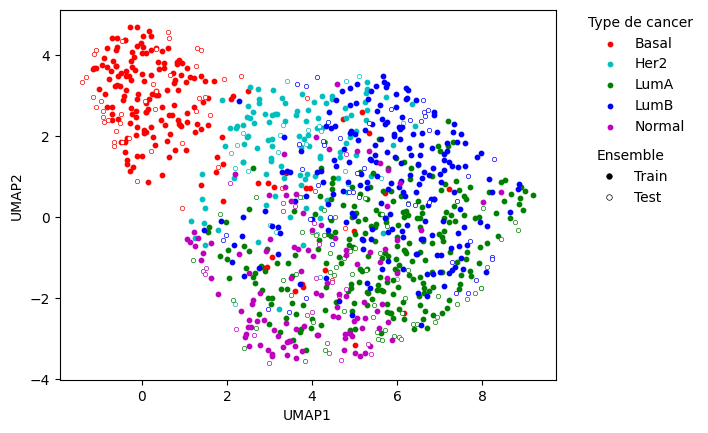

In [8]:
# Cast en DataFrame
X_tr_umap_df = pd.DataFrame(X_tr_umap)
X_tst_umap_df = pd.DataFrame(X_tst_umap)

colors = ["r", "c", "g", "b", "m"]

# Figure UMAP
plt.figure()
for target, color in zip(targets, colors): 
    plt.scatter(X_tr_umap_df.loc[Y_train == target,0], X_tr_umap_df.loc[Y_train == target, 1], 
                color = color, s = 10, label = target)
    plt.scatter(X_tst_umap_df.loc[Y_test == target,0], X_tst_umap_df.loc[Y_test == target, 1], 
                s = 10, edgecolors = color, color ="white", linewidth = 0.5)

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

# Légende d'entraînement et de test différente
legend_elements = [Line2D([0], [0], marker = "o", markerfacecolor = "black", 
                          label = "Train", color = "w", markeredgewidth = 0.5,
                          markeredgecolor= "black", markersize=4), 
                   Line2D([0], [0], marker = "o", markerfacecolor = "w", 
                          markeredgewidth= 0.5, markeredgecolor= "black",
                          label = "Test", color = "w", markersize=4)]
legend_supp = plt.legend(handles=legend_elements, loc = "center right",
                         bbox_to_anchor=(1.25, 0.55), frameon = False, 
                         title = "Ensemble")
plt.legend(loc = "upper left", bbox_to_anchor=(1.04, 1.02), frameon = False,
           title = "Type de cancer")
plt.gca().add_artist(legend_supp)

### **Étape II : Création d'un réseau de neurones artificiel pour un problème de régression avec un auto-encodeur**

#### <u>Binarisation des étiquettes</u>

In [7]:
lblbin = LabelBinarizer()
# Transformation + cast en Tensor
Y = torch.Tensor(lblbin.fit_transform(labels))

# Fabrication des échantillons d'entraînement et de test (cast en Tensor)
X_train, X_test, Y_train, Y_test = train_test_split(torch.Tensor(brca_data.T), torch.Tensor(Y),test_size=0.2)

#### <u>Fonction d'initialisation de l'autoencodeur</u>


In [8]:
def buildModel(inSize, outSize, width, bnSize) :

    """
    Construit un autoencodeur avec 5 couches (toutes ReLU sauf pour la 
    couche centrale (espace latent)).

        Paramètres:
            inSize (int): taille des données d'entrée
            outSize (int): taille des données de sortie
            width (int): taille à travers le réseau (nombre de neurones entrant
                ou sortant d'une couche si non spécifié)
            bnSize (int): taille de l'espace latent

        Retourne:
            model (Sequential): modèle au complet (autoencodeur)
            model[0:5] (Sequential): partie encodeur du modèle
    """

    model = nn.Sequential(
        nn.Linear(inSize, width),
        nn.ReLU(),
        nn.Linear(width, width),
        nn.ReLU(),
        nn.Linear(width, bnSize), # couche centrale
        nn.Linear(bnSize, width),
        nn.ReLU(),
        nn.Linear(width, outSize),
    )

    return model, model[0:5]


#### <u>Fonction d'entraînement de l'autoencodeur</u>

In [9]:
def trainModel(model, X_train, X_test, epochs, adamPenalty) : 

    """
    Entraîne un autoencodeur.

        Paramètres:
            model (Sequential): Modèle à entraîner
            X_train (Tensor): Données transcriptomiques d'entraînement
            X_test (Tensor): Données transcriptomiques de test
            epochs (int): Dombre d'époques d'entraînement
            adamPenalty (float): Pénalité utlisé dans l'algorithme
                d'optimisation Adam

        Retourne:
            trainLosses (list): Erreur quadratique moyenne en réel et prédit 
                de l'ensemble d'entraînement
            testLosses (list): Erreur quadratique moyenne en réel et prédit 
                de l'ensemble de test
            trainAccs (list): Corrélation de Pearson (0 à 1) entre réel et
                prédit de l'ensemble d'entraînement
            testAccs (list): Corrélation de Pearson (0 à 1) entre réel et 
                prédit de l'ensemble de test
    """

    optimizer = torch.optim.Adam(model.parameters(), lr = adamPenalty, weight_decay = adamPenalty)
    trainLosses, testLosses, trainAccs, testAccs = [], [], [], []

    for epoch in range(epochs) :

        optimizer.zero_grad() # réinitialiser le gradient à zéro

        outTrain = model(X_train)
        outTest = model(X_test)

        # Erreur
        trainError = nn.functional.mse_loss(outTrain, X_train)
        testError = nn.functional.mse_loss(outTest, X_test)

        # Précision
        trainAcc = pearsonr(outTrain.flatten().detach().numpy(), X_train.flatten().detach().numpy()).statistic 
        testAcc = pearsonr(outTest.flatten().detach().numpy(), X_test.flatten().detach().numpy()).statistic

        # Ajout aux listes
        [trainLosses.append(float(trainError)), testLosses.append(float(testError)), trainAccs.append(float(trainAcc)), testAccs.append(float(testAcc))]

        trainError.backward()
        optimizer.step()

        # Visualisation en temps réel de l'entraînement
        if epoch % 10 == 0 : 
            print(f"Epoch {epoch} --- Train Error : {round(float(trainError), 2)} ~ Test Error : {round(float(testError), 2)} ~ Train Acc : {round(float(trainAcc), 2)} ~ Test Acc : {round(float(testAcc), 2)} ")

    return trainLosses, testLosses, trainAccs, testAccs



#### <u>Création de l'autoencodeur</u>

In [10]:
# Modèle d'autoencodeur
ae, en = buildModel(X_train.shape[1], X_train.shape[1], 100, 2)
# Entraînement du modèle
trainMSE, testMSE, trainCorr, testCorr = trainModel(ae, X_train, X_test, 200, 0.001)

Epoch 0 --- Train Error : 0.18 ~ Test Error : 0.18 ~ Train Acc : 0.0 ~ Test Acc : 0.0 
Epoch 10 --- Train Error : 0.13 ~ Test Error : 0.13 ~ Train Acc : 0.09 ~ Test Acc : 0.09 
Epoch 20 --- Train Error : 0.11 ~ Test Error : 0.11 ~ Train Acc : 0.21 ~ Test Acc : 0.21 
Epoch 30 --- Train Error : 0.09 ~ Test Error : 0.09 ~ Train Acc : 0.31 ~ Test Acc : 0.31 
Epoch 40 --- Train Error : 0.06 ~ Test Error : 0.06 ~ Train Acc : 0.37 ~ Test Acc : 0.37 
Epoch 50 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.64 ~ Test Acc : 0.63 
Epoch 60 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.64 ~ Test Acc : 0.63 
Epoch 70 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.65 ~ Test Acc : 0.64 
Epoch 80 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.65 
Epoch 90 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.65 
Epoch 100 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.65 
Epoch 110 --

#### <u>Visualisation de la performance</u>

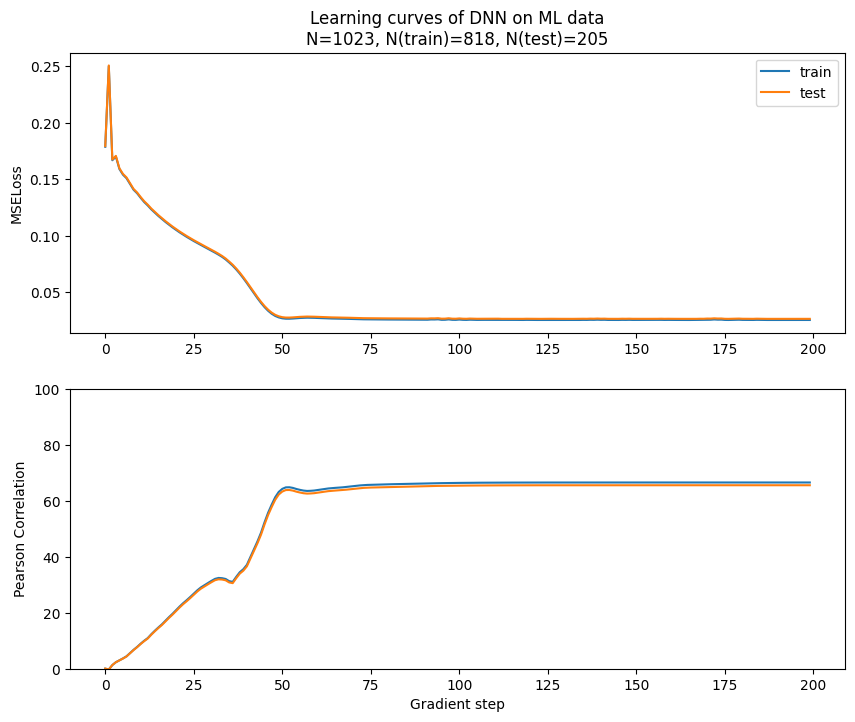

In [12]:
# Conversion de la précision en %
trainCorrPct = [corr * 100 for corr in trainCorr]
testCorrPct = [corr * 100 for corr in testCorr]

# Apprentissage
plot_learning_curves(trainMSE, testMSE, trainCorrPct, testCorrPct, brca_data, X_train, X_test)

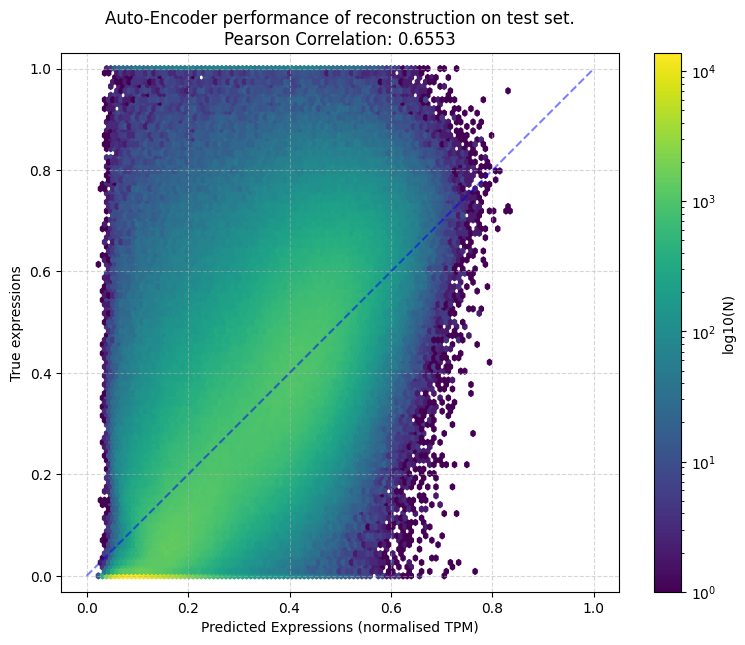

In [14]:
# Performance
plot_ae_performance(ae, X_test)

### **Étape III: Implémentation d'un Variational Auto-Encoder (VAE)**

#### <u>Initialisation des classes et fonctions des auto-encodeurs variationnels</u>

In [16]:
class VariationalEncoder(nn.Module):
    def __init__(self, insize, latent_dims, width = 100):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(insize, width)
        self.linear2 = nn.Linear(width, latent_dims)
        self.linear3 = nn.Linear(width, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        #self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale # .cuda()
        self.kl = 0
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, insize, latent_dims, width = 100):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, width)
        self.linear2 = nn.Linear(width, insize)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        return self.linear2(z)
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, insize, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(insize, latent_dims)
        self.decoder = Decoder(insize, latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [21]:
def train_Variational_Autoencodeur (insize, bnsize, X_train, X_test, nepochs = 1000, printstep=100, wd = 1e-3, lr = 0.0001):
    DNN = VariationalAutoencoder(insize, bnsize)
    optimizer = torch.optim.Adam(DNN.parameters(), lr = lr, weight_decay = wd)
    trainLosses, testLosses, trainAccs, testAccs = [],[],[],[]
    
    for epoch in range(nepochs):

        optimizer.zero_grad() # réinitialiser le gradient à zéro

        outTrain = DNN(X_train)
        outTest = DNN(X_test)

        # Erreur
        trainError = nn.functional.mse_loss(outTrain, X_train)
        testError = nn.functional.mse_loss(outTest, X_test)

        # Précision
        trainAcc = pearsonr(outTrain.flatten().detach().numpy(), X_train.flatten().detach().numpy()).statistic 
        testAcc = pearsonr(outTest.flatten().detach().numpy(), X_test.flatten().detach().numpy()).statistic

        trainError.backward()
        optimizer.step()

        if epoch % printstep == 0 : 
            print(f"Epoch {epoch} --- Train Error : {round(float(trainError), 2)} ~ Test Error : {round(float(testError), 2)} ~ Train Acc : {round(float(trainAcc*100), 2)} ~ Test Acc : {round(float(testAcc*100), 2)} ")

        [trainLosses.append(float(trainError)), testLosses.append(float(testError)), trainAccs.append(float(trainAcc*100)), testAccs.append(float(testAcc*100))]
    return trainLosses, testLosses, trainAccs, testAccs

#### <u>Utilisation des données initialisées précedemment</u>

#### <u>Création du modèle</u>

In [22]:
vae = VariationalAutoencoder(insize, 2)
vae(X_train)
tr_losses, tst_losses, tr_accs, tst_accs = train_Variational_Autoencodeur(X_train.shape[1], 2, X_train, X_test)

Epoch 0 --- Train Error : 0.24 ~ Test Error : 0.24 ~ Train Acc : 0.09 ~ Test Acc : 0.02 
Epoch 100 --- Train Error : 0.14 ~ Test Error : 0.14 ~ Train Acc : 7.47 ~ Test Acc : 7.31 
Epoch 200 --- Train Error : 0.11 ~ Test Error : 0.11 ~ Train Acc : 17.36 ~ Test Acc : 17.06 
Epoch 300 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 58.54 ~ Test Acc : 57.63 
Epoch 400 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 66.28 ~ Test Acc : 65.29 
Epoch 500 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 66.45 ~ Test Acc : 65.46 
Epoch 600 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 66.48 ~ Test Acc : 65.49 
Epoch 700 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 66.49 ~ Test Acc : 65.5 
Epoch 800 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 66.5 ~ Test Acc : 65.51 
Epoch 900 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 66.51 ~ Test Acc : 65.52 


#### <u>Visualisation de l'apprentissage et de la performance</u>

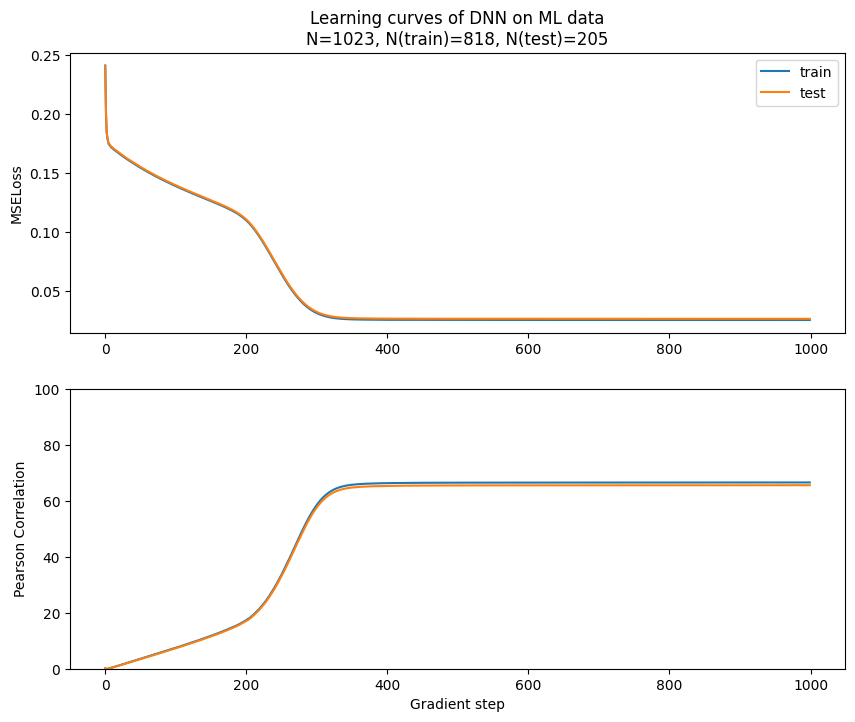

In [28]:
plot_learning_curves(tr_losses, tst_losses, tr_accs, tst_accs, brca_data, X_train, X_test)

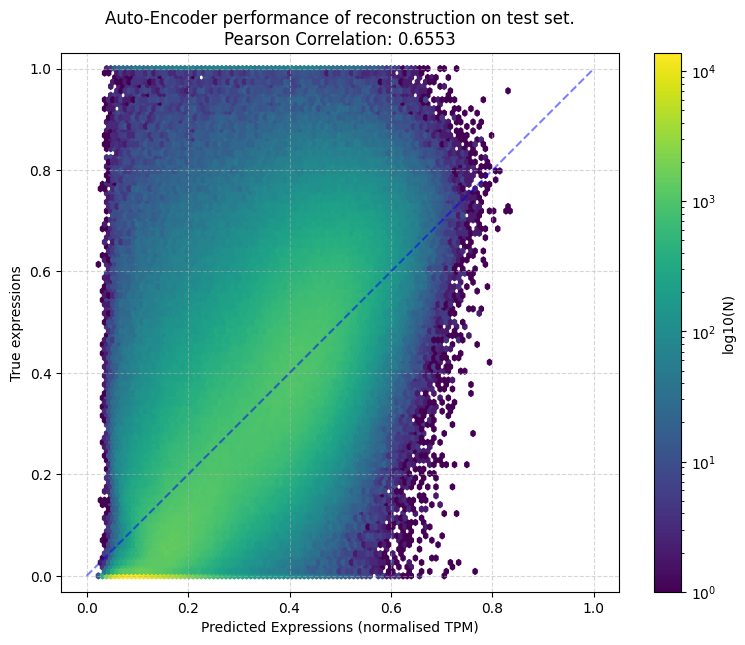

In [26]:
# Visualisation avec un diagramme de densité
common.plotting.plot_ae_performance(ae, X_test) # À modifier 

### **Étape IV : UMAP supervisé**

In [7]:
lblenc = LabelEncoder()
lblenc.fit(labels)
Y = lblenc.transform(labels)
X_train, X_test, Y_train, Y_test = train_test_split(brca_data.T, Y, test_size = 0.2)
mapper = umap.UMAP(verbose = 1, n_components = 2, min_dist=1., 
    n_neighbors =5, n_epochs = 1000).fit(X_train,  y = Y_train)

UMAP(min_dist=1.0, n_epochs=1000, n_neighbors=5, verbose=1)
Fri Dec  8 20:05:01 2023 Construct fuzzy simplicial set
Fri Dec  8 20:05:03 2023 Finding Nearest Neighbors
Fri Dec  8 20:05:06 2023 Finished Nearest Neighbor Search
Fri Dec  8 20:05:09 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Fri Dec  8 20:05:12 2023 Finished embedding


In [8]:
X_tr_umap = mapper.transform(X_train)
X_tst_umap = mapper.transform(X_test)

Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


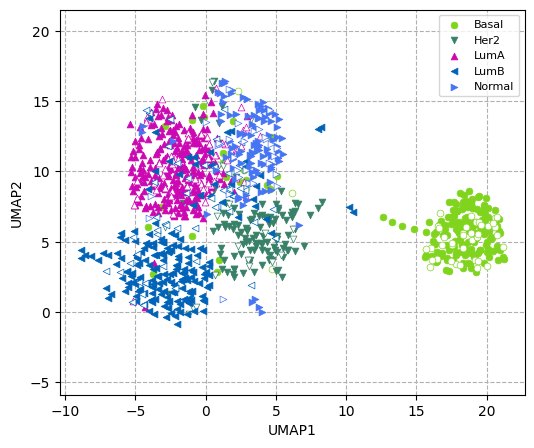

In [10]:
common.plotting.plot_umap(X_tr_umap, X_tst_umap, lblenc.inverse_transform(Y_train), lblenc.inverse_transform(Y_test), labels, s = 24)

## **Deuxième partie : Projet**

### **Hyper-paramétrisation et comparaison des performances des auto-encodeurs et des VAE pour la régression sur de vraies données transcriptomiques des cancers**